In [52]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [54]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-2qwz7obw
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-2qwz7obw
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=ebf89a48f15e12107cb87d92f67ad8d30f669ba3b3bfee7c9b23f513caaa7deb
  Stored in directory: /tmp/pip-ephem-wheel-cache-105rxlln/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [55]:
!pip install pyedflib

     |████████████████████████████████| 1.7 MB 6.5 MB/s 


In [56]:
!pip install padasip

  Created wheel for padasip: filename=padasip-1.1.1-py3-none-any.whl size=52974 sha256=3753c9d9858019a91cb01a08bfaa3fe33e8bd60d0ab83783091ecb9143e4f8cf
  Stored in directory: /root/.cache/pip/wheels/b2/22/4d/4b4fa2b27cceaa4f00e02f59d17a9aa320f5e21284db6d0c33
Successfully built padasip


In [57]:
fileNames = []
fileName_str = []
#Change the number here to read different files
for i in range(10,11,1):
  name_str = ''
  if(i<10):
    name_str = 'b00'
  else:
    name_str = 'b0'
  fileNames.append(name_str+ str(i)+'.edf')
  fileName_str.append(name_str+ str(i))

In [58]:
import pyedflib
import numpy as np
from scipy import signal
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import scale
import padasip as pa
from scipy import signal
from keras.layers import LeakyReLU
original_scg = []
original_ecg = []
class DataUtils:

    def __init__(self) -> None:
        super().__init__()
        self.fileNames = fileNames
    

    def readData(self, sigNum, path="/content/drive/MyDrive/Colab Notebooks/basal/"):
        file_name = path + self.fileNames[sigNum]
        #print(file_name)
        #file_name =  self.fileNames[sigNum]
        f = pyedflib.EdfReader(file_name)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        print("Reading file:: ",file_name)
        print("different columns:: ",signal_labels)
        print("total number of samples",f.getNSamples())
        abdECG = np.zeros((1, f.getNSamples()[0]))
        scg = np.zeros((1, f.getNSamples()[0]))
        scg[0, :] = f.readSignal(3)
        scg = scale(scg, axis=1)
        #scg[0, :] = scale(self.butter_bandpass_filter(scg, 1, 200, 1000), axis=1)
        #for i in np.arange(0, n-2):
        abdECG[0, :] = f.readSignal(0)
        abdECG = scale(abdECG, axis=1)
        #abdECG = scale(self.butter_bandpass_filter(abdECG, 1, 110, 1000), axis=1)
        print("before downsampling",abdECG.shape[1])
        abdECG = signal.resample(abdECG, int(abdECG.shape[1] / 5), axis=1)
        scg = signal.resample(scg, int(scg.shape[1] / 5), axis=1)

        # # differencing code starts
        # scg = np.diff(scg)
        # abdECG = np.diff(abdECG)
        # # differencing code ends

        print("after downsampling",abdECG.shape[1])


        #changed the return sequence, so that converion will be from SCG to ECG
        return  scg, abdECG

    def windowingSig(self, sig1, sig2, windowSize=15):
        signalLen = sig2.shape[1]
        signalsWindow1 = [sig1[:, int(i):int(i + windowSize)].transpose() for i in range(0, signalLen - windowSize, windowSize)]
        signalsWindow2 = [sig2[:, int(i):int(i + windowSize)].transpose() for i in range(0, signalLen - windowSize, windowSize)]
        print("SCG shape after windowing:: ",np.array(signalsWindow1).shape)
        print("ECG shape after windowing:: ",np.array(signalsWindow2).shape)

        return signalsWindow1, signalsWindow2

    def adaptFilterOnSig(self, src, ref):
        f = pa.filters.FilterNLMS(n=4, mu=0.1, w="random")
        for index, sig in enumerate(src):
            try:
                y, e, w = f.run(ref[index][:, 0], sig)
                ref[index][:, 0] = e
            except:
                pass

        return ref

    def calculateICA(self, sdSig, component=7):
        ica = FastICA(n_components=component, max_iter=1000)
        icaRes = []
        for index, sig in enumerate(sdSig):
            try:
                icaSignal = np.array(ica.fit_transform(sig))
                icaSignal = np.append(icaSignal, sig[:, range(2, 4)], axis=1)
                icaRes.append(icaSignal)
            except:
                pass
        return np.array(icaRes)

    def createDelayRepetition(self, signal, numberDelay=4, delay=10):
        signal = np.repeat(signal, numberDelay, axis=0)
        #print("createDelayRepetition::",signal.shape)
        for row in range(1, signal.shape[0]):
            signal[row, :] = np.roll(signal[row, :], shift=delay * row)
        
        #print("createDelayRepetition 2::",signal.shape)
        return signal

    def __butter_bandpass(self, lowcut, highcut, fs, order=5):
        #print("00")
        nyq = 0.5 * fs
        #print("0")
        low = lowcut / nyq
        #print("11")
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        #print("1")
        return b, a

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=3, axis=1):
        #print("In butter_bandpass_filter")
        b, a = self.__butter_bandpass(lowcut, highcut, fs, order=order)
        y = filtfilt(b, a, data, axis=axis)
        #print("2")
        return y

In [59]:
from sklearn.model_selection import train_test_split
 
#from Utils.DataUtils import DataUtils
import numpy as np
import copy
 
class TrainUtils:
    def __init__(self) -> None:
        super().__init__()
        self.dataUtils = DataUtils()
 
    def prepareData(self, delay=5, path="/content/drive/MyDrive/Colab Notebooks/basal/b010.edf"):
        scgAll, ecg = self.dataUtils.readData(0,path)
        print(scgAll.shape)
        #print("scg shape:: ",ecg.shape)
        scgAll = scgAll[range(1), :]
        #print("Number of samples:: ",scg.shape)
        delayNum = scgAll.shape[0]
        ecgAll = self.dataUtils.createDelayRepetition(ecg, delayNum, delay)
        #print("scg all shape:: ",ecgAll.shape)
        for i in range(1, len(fileNames)):
            scg, ecg = self.dataUtils.readData(i,path)
            print("Number of samples:: ",ecg.shape)
            scg = scg[range(1), :]
            ecgDelayed = self.dataUtils.createDelayRepetition(ecg, 1, delay)
            scgAll = np.append(scgAll, scg, axis=1)
            ecgAll = np.append(ecgAll, ecgDelayed, axis=1)
        #print("SCG all merged shape:: ", scg.shape)
        print("ECG all merged shape:: ", ecgAll.shape)

        original_scg = scgAll
        original_ecg = ecgAll
        scgWindows, ecgWindows = self.dataUtils.windowingSig(scgAll, ecgAll, windowSize=1000)
        # ecgWindows = self.dataUtils.adaptFilterOnSig(scgWindows, ecgWindows)
        # scgWindows = self.dataUtils.calculateICA(scgWindows, component=2)
        return scgWindows, ecgWindows
 
    def trainTestSplit(self, sig, label, trainPercent, shuffle=True):
        print("Splitting into train and test:: ")
        X_train, X_test, y_train, y_test = train_test_split(sig, label, train_size=trainPercent, shuffle=False)
        X_train = np.array(X_train)
        #X_train = self.window_the_data(X_train,  60)
        X_test = np.array(X_test)
        #X_test = self.window_the_data(X_test,  60)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        return X_train, X_test, y_train, y_test
 
    def window_the_data(self,data,window=32):
      r = list()
      for i, mat in enumerate(data):
        s = 0
        a = list()
        print(data.shape)
        while s + window < 256:
          a.append(copy.deepcopy(mat[s : s + window].T))
          # for i,x in enumerate(a):
            # a[i] = scaler.fit_transform(x)
          s += 2
        r.append(copy.deepcopy(a))
        #print(r.shape())
 
 
      r = np.array(r)
      return copy.deepcopy(r)

In [60]:
!pip install --upgrade keras

In [61]:
from __future__ import print_function, division

import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K
from keras import Input, Model
from keras.layers import Conv1D, UpSampling1D, LeakyReLU, Dropout, Lambda, Embedding, Bidirectional, LSTM, Dense, Flatten, Layer, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers import InstanceNormalization
#from keras_self_attention import ScaledDotProductAttention
#from keras_self_attention.backend import regularizers
from sklearn.preprocessing import scale

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Normalization

#from Utils.DataUtils import DataUtils


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # self.ffn = Sequential(
        #     [Dense(ff_dim, activation="relu"), Dense(embed_dim), ]
        # )
        #print("apply layered normalization")
        self.layernorm1 = LayerNormalization(epsilon=1e-4)
        # self.layernorm2 = LayerNormalization(epsilon=1e-6)
        #print("apply dropout")
        self.dropout1 = Dropout(rate)
        # self.dropout2 = Dropout(rate)

    def call(self, inputs):
        #print("In call function of transformer")
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs * attn_output)
        # ffn_output = self.ffn(out1)
        # ffn_output = self.dropout2(ffn_output)
        return out1 
    def get_config(self):
        """
            For rebuilding models on load time.
        """
        
        #config = {
        #    'output_dim': self.output_dim,
        #    'units': self.units,
        #    'return_probabilities': self.return_probabilities
        #}
        base_config = super(TransformerBlock, self).get_config()
        return dict(list(base_config.items()))

def batch_creation(dataX, dataY, batch_size,batch_idx):
    # get 64 pictures from the files
    # process_batchA = []
    # process_batchB = []
    X = dataX[batch_idx*batch_size:batch_idx*batch_size+batch_size]
    y = dataY[batch_idx*batch_size:batch_idx*batch_size+batch_size]
    #print(current_pic)
    # call read picture
    # for i in range(len(current_pic)):
    #     filename = os.path.join(image_paths, current_pic[i])
    #     A,B = read_picture(filename)
    #     # normalize picture
    #     A = normalize_picture(A)
    #     B = normalize_picture(B)
    #     #append 2 pic in a list
    #     process_batchA.append(A)
    #     process_batchB.append(B)
    
    return X, y

class CycleGAN:
    def __init__(self, row, col):
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                # Restrict TensorFlow to only use the fourth GPU
                tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

                # Currently, memory growth needs to be the same across GPUs
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            except RuntimeError as e:
                # Memory growth must be set before GPUs have been initialized
                print(e)
        # Input shape
        self.dataUtils = DataUtils()
        self.img_rows = row
        self.img_cols = col
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols)
        self.img_shape_b = (self.img_rows,1)

        # Configure data loader
        self.dataset_name = 'ECG2FECG'

        print("1")
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2 ** 4)
        self.disc_patch = (self.img_rows, 1)

        # Number of filters in the first layer of G and D
        self.gf = 6
        self.df = 13

        # Loss weights
        self.lambda_cycle = 4.0  # Cycle-consistency loss
        self.lambda_id = 0.01 * self.lambda_cycle  # Identity loss

        optimizer = Adam()
        # Build and compile the discriminators
        self.d_A = self.build_discriminator(self.img_shape)
        self.d_B = self.build_discriminator(self.img_shape_b)
        self.d_A.compile(loss='MSE',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='MSE',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        # -------------------------
        # Construct Computational
        #   Graph of Generators
        # -------------------------

        # Build the generators
        self.g_AB = self.build_generator(self.img_shape)
        self.g_BA = self.build_generator(self.img_shape_b)

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape_b)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)

        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        #print("1")
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        #print("2")
        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False
        #print("3")

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)
        #print("4")

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       fake_B, fake_A,
                                       reconstr_A, reconstr_B])
        print("model created")
        self.combined.compile(loss=['huber_loss', 'huber_loss',
                                    'huber_loss', 'huber_loss', 'huber_loss',
                                    'huber_loss'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)
        print("Model compiled")

    # Define custom loss
    def custom_loss(self):

        # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
        def loss(y_true, y_pred):
            return K.mean(y_true * K.log(y_true / y_pred + K.epsilon()))

        # Return a function
        return loss

    def build_generator(self,img_shape):
        """U-Net Generator"""
        print("In build generator")
        def conv1DWithSINE(layer_input, filters, f_size=30):
            """Layers used during downsampling"""
            d = Conv1D(filters, kernel_size=f_size, padding='same', activation=tf.nn.leaky_relu)(layer_input)
            d = InstanceNormalization()(d)
            return d

        def multiply(x):
            mask,image  = x
            return image* K.clip(mask,0.8,1)

        input = Input(shape=img_shape)
        print("Input shape:: ", input.shape)
        #value = conv1DWithSINE(input, input.shape[2], f_size=30)
        value = conv1DWithSINE(input, 30, f_size=30)
        print(" shape after conv1d :: ", value.shape)

        print("apply attention.")
        att = TransformerBlock(input.shape[1], 2)(value)
        print("shape after attention:: ",att.shape )
        att = Normalization(axis=1)(att)
        print("shape after normalizing attention:: ",att.shape )

        remainedInput = Lambda(multiply)([att, value])
        print("shape after apply lambda:: ",remainedInput.shape )

        output_img = conv1DWithSINE(remainedInput, 17, f_size=30)
        print("input shape after first conv1d:: ",output_img.shape)
        output_img = conv1DWithSINE(output_img, 13, f_size=30)
        print("input shape after second conv1d:: ",output_img.shape)
        output_img = conv1DWithSINE(output_img, 13, f_size=30)
        print("input shape after third conv1d:: ",output_img.shape)
        output_img = conv1DWithSINE(output_img, 1, f_size=1)
        print("input shape after fourth conv1d:: ",output_img.shape)

        return Model(input, output_img)

    def build_discriminator(self,img_shape):
        print("In building discriminator")
        def d_layer(layer_input, filters, f_size=13, normalization=True):
            """Discriminator layer"""
            d = Conv1D(filters, kernel_size=f_size, padding='same',activation=tf.nn.leaky_relu)(layer_input)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=img_shape)
        print("input shape:: ",img.shape)
        d1 = d_layer(img, self.df)
        print("input shape after first conv1d:: ",d1.shape)
        d2 = d_layer(d1, 13)
        print("input shape after second conv1d:: ",d2.shape)
        d3 = d_layer(d2, 13)
        print("input shape after third conv1d:: ",d3.shape)
        validity = d_layer(d3, 1)
        # validity = d_layer(d3, img.shape[1])
        print("final shape after 4th layer:: ",validity.shape)


        return Model(img, validity)

    def train(self, x_train, y_train, epochs, batch_size=1, sample_interval=20):
        print("Num Samples", x_train.shape[0])
        print("In train:: ")
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_idx in range(x_train.shape[0]//batch_size):
                batchA, batchB = batch_creation(x_train, y_train, batch_size,batch_idx)
                batchA = np.asarray(batchA)
                batchB = np.asarray(batchB)
                imgs_A = batchA
                imgs_B = batchB
                imgs_B = np.reshape(imgs_B, (-1, x_train.shape[1], x_train.shape[2]))
                imgs_A = np.reshape(imgs_A, (-1, x_train.shape[1], x_train.shape[2]))
                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to the other domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)
                # Translate images back to original domain
                reconstr_A = self.g_BA.predict(fake_B)
                reconstr_B = self.g_AB.predict(fake_A)
                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_B, imgs_A,
                                                       reconstr_A, reconstr_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                      % (epoch, epochs,
                         batch_idx, 1,
                         d_loss[0], 100 * d_loss[1],
                         g_loss[0],
                         np.mean(g_loss[1:3]),
                         np.mean(g_loss[3:5]),
                         np.mean(g_loss[5:6]),
                         elapsed_time))

                # If at save interval => save generated image samples
                #print("shape of image a",imgs_A.shape)
                #print("shape of image b",imgs_B.shape)
                if batch_idx % sample_interval == 0:
                    self.sample_images(epoch, batch_idx, imgs_A, imgs_B)
        self.g_AB.save("ECG2FECG.h5", overwrite=True)
        self.g_BA.save("FECG2ECG.h5", overwrite=True)

    def sample_images(self, epoch, batch_idx, imgs_A, imgs_B):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        # Demo (for GIF)
        # imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        # imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        #print("shape of gen",gen_imgs.shape)
        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0

        # gen_imgs[1] = gen_imgs[0]-gen_imgs[1]
        try:
            for i in range(r):
                for j in range(c):
                    for bias in range(1):
                        #gen_imgs[cnt][:, bias] = scale(self.dataUtils.butter_bandpass_filter(gen_imgs[cnt][:, bias], 10, 50, 200, axis=0), axis=0)
                        #gen_imgs[cnt][:, bias] = scale(gen_imgs[cnt][:, bias], axis=0)
                        if np.max(gen_imgs[cnt][:, bias]) != 0:
                            gen_imgs[cnt][:, bias] = gen_imgs[cnt][:, bias] / np.max(gen_imgs[cnt][:, bias])
                        axs[i, j].plot(gen_imgs[cnt][:, bias] + bias)
                    axs[i, j].set_title(titles[j])
                    cnt += 1
            # fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_idx))
            plt.close()
        except:
            pass

In [62]:
from keras import backend as K
from keras import regularizers, constraints, initializers, activations
from keras.layers import TimeDistributed
#from keras.layers.recurrent import Recurrent
from tensorflow.keras.layers import InputSpec




class AttentionDecoder():

    def __init__(self, units, output_dim,
                 activation='tanh',
                 return_probabilities=False,
                 name='AttentionDecoder',
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        """
        Implements an AttentionDecoder that takes in a sequence encoded by an
        encoder and outputs the decoded states
        :param units: dimension of the hidden state and the attention matrices
        :param output_dim: the number of labels in the output space
        references:
            Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio.
            "Neural machine translation by jointly learning to align and translate."
            arXiv preprint arXiv:1409.0473 (2014).
        """
        self.units = units
        self.output_dim = output_dim
        self.return_probabilities = return_probabilities
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionDecoder, self).__init__(**kwargs)
        self.name = name
        self.return_sequences = True  # must return sequences

    def build(self, input_shape):
        """
          See Appendix 2 of Bahdanau 2014, arXiv:1409.0473
          for model details that correspond to the matrices here.
        """

        self.batch_size, self.timesteps, self.input_dim = input_shape

        if self.stateful:
            super(AttentionDecoder, self).reset_states()

        self.states = [None, None]  # y, s

        """
            Matrices for creating the context vector
        """

        self.V_a = self.add_weight(shape=(self.units,),
                                   name='V_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.W_a = self.add_weight(shape=(self.units, self.units),
                                   name='W_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.U_a = self.add_weight(shape=(self.input_dim, self.units),
                                   name='U_a',
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   constraint=self.kernel_constraint)
        self.b_a = self.add_weight(shape=(self.units,),
                                   name='b_a',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the r (reset) gate
        """
        self.C_r = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_r = self.add_weight(shape=(self.units, self.units),
                                   name='U_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_r = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_r',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_r = self.add_weight(shape=(self.units,),
                                   name='b_r',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        """
            Matrices for the z (update) gate
        """
        self.C_z = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_z = self.add_weight(shape=(self.units, self.units),
                                   name='U_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_z = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_z',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_z = self.add_weight(shape=(self.units,),
                                   name='b_z',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for the proposal
        """
        self.C_p = self.add_weight(shape=(self.input_dim, self.units),
                                   name='C_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_p = self.add_weight(shape=(self.units, self.units),
                                   name='U_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_p = self.add_weight(shape=(self.output_dim, self.units),
                                   name='W_p',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_p = self.add_weight(shape=(self.units,),
                                   name='b_p',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        """
            Matrices for making the final prediction vector
        """
        self.C_o = self.add_weight(shape=(self.input_dim, self.output_dim),
                                   name='C_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.U_o = self.add_weight(shape=(self.units, self.output_dim),
                                   name='U_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.W_o = self.add_weight(shape=(self.output_dim, self.output_dim),
                                   name='W_o',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)
        self.b_o = self.add_weight(shape=(self.output_dim,),
                                   name='b_o',
                                   initializer=self.bias_initializer,
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)

        # For creating the initial state:
        self.W_s = self.add_weight(shape=(self.input_dim, self.units),
                                   name='W_s',
                                   initializer=self.recurrent_initializer,
                                   regularizer=self.recurrent_regularizer,
                                   constraint=self.recurrent_constraint)

        self.input_spec = [
            InputSpec(shape=(self.batch_size, self.timesteps, self.input_dim))]
        self.built = True

    def _time_distributed_dense(self,x, w, b=None, dropout=None,
                                input_dim=None, output_dim=None,
                                timesteps=None, training=None):
        """Apply `y . w + b` for every temporal slice y of x.
        # Arguments
            x: input tensor.
            w: weight matrix.
            b: optional bias vector.
            dropout: wether to apply dropout (same dropout mask
                for every temporal slice of the input).
            input_dim: integer; optional dimensionality of the input.
            output_dim: integer; optional dimensionality of the output.
            timesteps: integer; optional number of timesteps.
            training: training phase tensor or boolean.
        # Returns
            Output tensor.
        """
        if not input_dim:
            input_dim = K.shape(x)[2]
        if not timesteps:
            timesteps = K.shape(x)[1]
        if not output_dim:
            output_dim = K.shape(w)[1]

        if dropout is not None and 0. < dropout < 1.:
            # apply the same dropout pattern at every timestep
            ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
            dropout_matrix = K.dropout(ones, dropout)
            expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
            x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)

        # collapse time dimension and batch dimension together
        x = K.reshape(x, (-1, input_dim))
        x = K.dot(x, w)
        if b is not None:
            x = K.bias_add(x, b)
        # reshape to 3D tensor
        if K.backend() == 'tensorflow':
            x = K.reshape(x, K.stack([-1, timesteps, output_dim]))
            x.set_shape([None, None, output_dim])
        else:
            x = K.reshape(x, (-1, timesteps, output_dim))
        return x

    def call(self, x):
        # store the whole sequence so we can "attend" to it at each timestep
        self.x_seq = x

        # apply the a dense layer over the time dimension of the sequence
        # do it here because it doesn't depend on any previous steps
        # thefore we can save computation time:
        self._uxpb = self._time_distributed_dense(self.x_seq, self.U_a, b=self.b_a,
                                             input_dim=self.input_dim,
                                             timesteps=self.timesteps,
                                             output_dim=self.units)

        return super(AttentionDecoder, self).call(x, )

    def get_initial_state(self, inputs):
        # apply the matrix on the first time step to get the initial s0.
        s0 = activations.tanh(K.dot(inputs[:, 0], self.W_s))

        # from keras.layers.recurrent to initialize a vector of (batchsize,
        # output_dim)
        y0 = K.zeros_like(inputs)  # (samples, timesteps, input_dims)
        y0 = K.sum(y0, axis=(1, 2))  # (samples, )
        y0 = K.expand_dims(y0)  # (samples, 1)
        y0 = K.tile(y0, [1, self.output_dim])

        return [y0, s0]

    def step(self, x, states):

        ytm, stm = states

        # repeat the hidden state to the length of the sequence
        _stm = K.repeat(stm, self.timesteps)

        # now multiplty the weight matrix with the repeated hidden state
        _Wxstm = K.dot(_stm, self.W_a)

        # calculate the attention probabilities
        # this relates how much other timesteps contributed to this one.
        et = K.dot(activations.tanh(_Wxstm + self._uxpb),
                   K.expand_dims(self.V_a))
        at = K.exp(et)
        at_sum = K.sum(at, axis=1)
        at_sum_repeated = K.repeat(at_sum, self.timesteps)
        at /= at_sum_repeated  # vector of size (batchsize, timesteps, 1)

        # calculate the context vector
        context = K.squeeze(K.batch_dot(at, self.x_seq, axes=1), axis=1)
        # ~~~> calculate new hidden state
        # first calculate the "r" gate:

        rt = activations.sigmoid(
            K.dot(ytm, self.W_r)
            + K.dot(stm, self.U_r)
            + K.dot(context, self.C_r)
            + self.b_r)

        # now calculate the "z" gate
        zt = activations.sigmoid(
            K.dot(ytm, self.W_z)
            + K.dot(stm, self.U_z)
            + K.dot(context, self.C_z)
            + self.b_z)

        # calculate the proposal hidden state:
        s_tp = activations.tanh(
            K.dot(ytm, self.W_p)
            + K.dot((rt * stm), self.U_p)
            + K.dot(context, self.C_p)
            + self.b_p)

        # new hidden state:
        st = (1 - zt) * stm + zt * s_tp

        yt = activations.softmax(
            K.dot(ytm, self.W_o)
            + K.dot(stm, self.U_o)
            + K.dot(context, self.C_o)
            + self.b_o)

        if self.return_probabilities:
            return at, [yt, st]
        else:
            return yt, [yt, st]

    def compute_output_shape(self, input_shape):
        """
            For Keras internal compatability checking
        """
        if self.return_probabilities:
            return (None, self.timesteps, self.timesteps)
        else:
            return (None, self.timesteps, self.output_dim)

    def get_config(self):
        """
            For rebuilding models on load time.
        """
        config = {
            'output_dim': self.output_dim,
            'units': self.units,
            'return_probabilities': self.return_probabilities
        }
        base_config = super(AttentionDecoder, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [63]:

from unittest import TestCase
import numpy as np

#from Utils.TrainUtils import TrainUtils
#from deeplearning.CycleGAN import CycleGAN


class TestCycleGAN(TestCase):

    def __init__(self, methodName: str = ...) -> None:
        super().__init__(methodName)
        self.trainUtils = TrainUtils()

    def test_trainSignal(self,path="/content/drive/MyDrive/Colab Notebooks/basal/b010.edf"):
        scgWindows, ecgWindows = self.trainUtils.prepareData(delay=2,path="/content/drive/MyDrive/Colab Notebooks/basal/")
        print("ecgWindows:: ",np.array(ecgWindows).shape)
        X_train, X_test, Y_train, y_test = self.trainUtils.trainTestSplit(scgWindows, ecgWindows, 0.75)
        X_train = np.reshape(X_train, [-1, X_train.shape[1], X_train.shape[2]])
        # X_test = np.reshape(X_test, [-1, X_test.shape[1], X_test.shape[2], 1])
        Y_train = np.reshape(Y_train, [-1, Y_train.shape[1], Y_train.shape[2]])
        
        print("Shape of x train and y train:: ",X_train.shape, Y_train.shape)
        print("Shape of x test and y test:: ",X_test.shape, y_test.shape)
        # y_test = np.reshape(Y_test, [-1, Y_test.shape[1], Y_test.shape[2], 1])
        cycleGAN = CycleGAN(X_train.shape[1], X_train.shape[2])
        print("model instantiated")
        cycleGAN.train(x_train=X_train, y_train=Y_train, epochs=1)
        return cycleGAN, X_test, y_test
    def divide_test_train(self,path="/content/drive/MyDrive/Colab Notebooks/basal/b010.edf"):
        scgWindows, ecgWindows = self.trainUtils.prepareData(delay=2,path="/content/drive/MyDrive/Colab Notebooks/basal/")
        X_train, X_test, Y_train, y_test = self.trainUtils.trainTestSplit(scgWindows, ecgWindows, 0.75)
        return X_train, X_test, Y_train, y_test


In [64]:
model = TestCycleGAN("test_trainSignal")

In [65]:
cycleGan, X_test, y_test = model.test_trainSignal()

Reading file::  /content/drive/MyDrive/Colab Notebooks/basal/b010.edf
different columns::  ['I', 'II', 'RESP', 'SCG']
total number of samples [1505000 1505000 1505000 1505000]
before downsampling 1505000
after downsampling 301000
(1, 301000)
ECG all merged shape::  (1, 301000)
SCG shape after windowing::  (300, 1000, 1)
ECG shape after windowing::  (300, 1000, 1)
ecgWindows::  (300, 1000, 1)
Splitting into train and test:: 
Shape of x train and y train::  (225, 1000, 1) (225, 1000, 1)
Shape of x test and y test::  (75, 1000, 1) (75, 1000, 1)
1
In building discriminator
input shape::  (None, 1000, 1)
input shape after first conv1d::  (None, 1000, 13)
input shape after second conv1d::  (None, 1000, 13)
input shape after third conv1d::  (None, 1000, 13)
final shape after 4th layer::  (None, 1000, 1)
In building discriminator
input shape::  (None, 1000, 1)
input shape after first conv1d::  (None, 1000, 13)
input shape after second conv1d::  (None, 1000, 13)
input shape after third conv1d::

In [ ]:
#model = TestcycleGAN("test_trainSignal")

In [ ]:
#cycleGan, X_test, y_test = model.test_trainSignal()

In [66]:
x_g_AB =cycleGan.g_AB.predict(X_test)
#x_g_BA = cycleGan.g_BA.predict(X_test)

In [67]:
# import pandas as pd
# import numpy as np

# a = np.array(y_test.flatten())
# b = x_g_AB.flatten()
# print(len(a), len(b))
# df1 = pd.DataFrame({ "ECG Original" : a})
# df2 = pd.DataFrame({ "ECG Predicted" : b})
# df1.to_csv("/content/drive/MyDrive/ECG_data/original_ECG_1.csv", index=False)
# df2.to_csv("/content/drive/MyDrive/ECG_data/generated_ECG_1.csv", index=False)




import pandas as pd
import numpy as np

# a = np.array(original_scg)
a = np.array(y_test.flatten())
b = x_g_AB.flatten()
print(len(a), len(b))
df1 = pd.DataFrame({ "ECG Original" : a})
df2 = pd.DataFrame({ "ECG Predicted" : b})
df1.to_csv("/content/drive/MyDrive/ECG_data/original_ECG_10.csv", index=False)
#df2.to_csv("/content/drive/MyDrive/ECG_data/generated_ECG_10.csv", index=False)


75000 75000


In [68]:
!pip install heartpy

In [69]:
import heartpy as hp
import matplotlib.pyplot as plt

sample_rate = 250

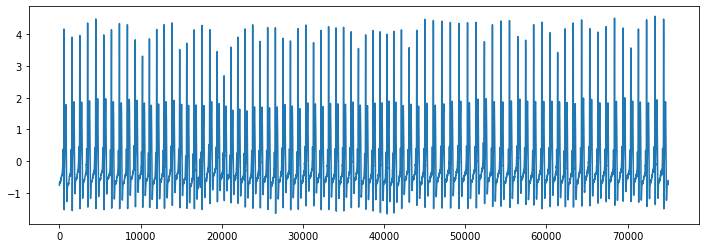

In [70]:
data = hp.get_data('/content/drive/MyDrive/ECG_data/original_ECG_10.csv')

plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

heart rates:  [ 128.20512821   65.50218341  234.375        25.55366269  125.
   66.07929515  234.375        84.26966292   41.43646409  123.96694215
   66.66666667  230.76923077   26.92998205  127.11864407   64.93506494
  241.93548387   25.29510961  125.           65.78947368  230.76923077
   26.17801047  121.95121951   66.37168142  234.375        28.30188679
  123.96694215   65.2173913   250.           26.26970228  123.96694215
   64.93506494  241.93548387   87.20930233 1500.           38.65979381
  126.05042017   65.50218341  234.375        27.07581227  125.
   65.2173913   254.23728814   30.99173554  123.96694215   65.78947368
  254.23728814   33.48214286  126.05042017   66.66666667  238.0952381
   30.67484663  129.31034483   65.50218341  241.93548387   28.68068834
  126.05042017   65.78947368  238.0952381    26.83363148  126.05042017
   66.96428571  223.88059701   28.84615385  122.95081967   64.93506494
  277.77777778   81.52173913   55.35055351  118.11023622   66.66666667
  241.935

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Warning: converting a masked element to nan.
  from ipykernel import kernelapp as app


<Figure size 864x288 with 0 Axes>

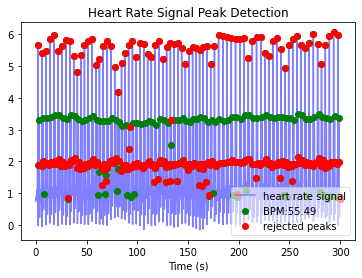

In [71]:
#run analysis
wd, m = hp.process(data[1:], sample_rate)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)
#print(len(wd['hr']))
#print(wd.keys())
#print(wd['RR_list'])
#heart rates
hrs = 60000/wd['RR_list']
print("heart rates: ",hrs)
#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [72]:

df2 = pd.DataFrame({ "Heart Rate" : np.array(hrs)})
df2.to_csv("/content/drive/MyDrive/ECG_data/hr_original_10.csv", index=False)


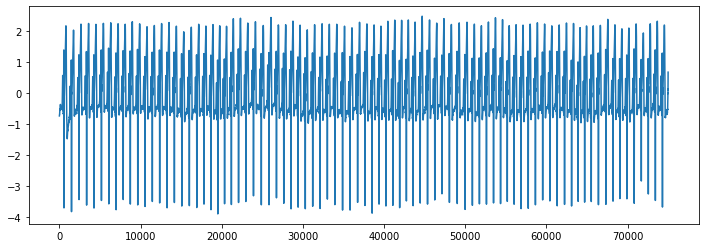

In [ ]:
data = hp.get_data('/content/drive/MyDrive/ECG_data/original_ECG_15.csv')

plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Warning: converting a masked element to nan.
  from ipykernel import kernelapp as app


heart rates:  [112.78195489 312.5        234.375       99.33774834 267.85714286
  24.63054187 300.         223.88059701  96.77419355 319.14893617
  24.63054187 312.5        254.23728814  95.54140127 288.46153846
  24.3902439  306.12244898 234.375       95.54140127 306.12244898
  25.38071066 306.12244898 230.76923077  98.03921569 300.
  25.         306.12244898 227.27272727  98.03921569 312.5
  25.38071066 306.12244898 238.0952381   96.77419355 294.11764706
  25.59726962 306.12244898 234.375       96.15384615 319.14893617
  26.97841727 312.5        241.93548387  94.33962264 326.08695652
  26.69039146 306.12244898 230.76923077  93.75       365.85365854
  25.12562814 319.14893617 238.0952381  100.67114094 263.15789474
  25.59726962 306.12244898 238.0952381   95.54140127 306.12244898
  25.95155709 306.12244898 230.76923077  95.54140127 326.08695652
  25.55366269 312.5        227.27272727 102.73972603 267.85714286
  25.08361204 306.12244898 241.93548387  99.33774834 277.77777778
  25.728987

<Figure size 864x288 with 0 Axes>

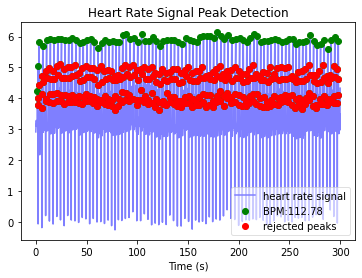

In [ ]:
#run analysis
wd, m = hp.process(data[1:], sample_rate)

#visualise in plot of custom size
plt.figure(figsize=(12,4))
hp.plotter(wd, m)
#print(len(wd['hr']))
#print(wd.keys())
#print(wd['RR_list'])
#heart rates
hrs = 60000/wd['RR_list']
print("heart rates: ",hrs)
#display computed measures
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [27]:

df2 = pd.DataFrame({ "Heart Rate" : np.array(hrs)})
df2.to_csv("/content/drive/MyDrive/ECG_data/hr_original_12.csv", index=False)


NameError: ignored

In [73]:
data = hp.get_data('/content/drive/MyDrive/ECG_data/hr_original_10.csv')

In [74]:
for i in range(len(data)):
  if data[i]>500: 
    data[i]=data[i]/10

In [75]:
import pandas as pd
import numpy as np
df2 = pd.DataFrame({ "Heart Rate" : np.array(data)})
df2.to_csv("/content/drive/MyDrive/ECG_data/hr_original_10.csv", index=False)


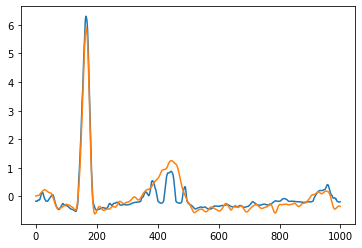

In [ ]:
plt.plot(x_g_AB[1])
plt.plot(y_test[1])

In [ ]:
#X_test_in = []
#x_g_AB_in = []
#inverse differencing
#for i in range(len(X_test)):
#  X_test_in.append((np.concatenate(([X_test[i][0]], X_test[i])).cumsum())[:x_g_AB.shape[1]])
#  x_g_AB_in.append((np.concatenate(([x_g_AB[i][0]], x_g_AB[i])).cumsum())[:x_g_AB.shape[1]])

In [ ]:
len(x_g_AB_in)

68

In [ ]:
len(x_g_AB_in[0])

1000

In [ ]:
# x_g_AB = np.array(x_g_AB_in).reshape(x_g_AB.shape[0],x_g_AB.shape[1],1)
# X_test = np.array(X_test_in).reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
def smooth(x,window_len=7,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [ ]:
x_g_AB_reshaped = x_g_AB.reshape(x_g_AB.shape[0],x_g_AB.shape[1])

In [ ]:
x_g_AB_reshaped.shape

(68, 1000)

In [ ]:
x_g_AB_smoothed = []
for i in range(len(x_g_AB_reshaped)):
  smoothed = smooth(x_g_AB_reshaped[i])
  x_g_AB_smoothed.append(smoothed[:len(x_g_AB_reshaped[i])])


In [ ]:
#          Testing functions
#################################################################################
def rmse(targets, predictions):
    return np.sqrt(np.mean((targets-predictions)**2))


def prd(targets, predictions):
    s1 = np.sum((targets-predictions)**2)
    s2 = np.sum(targets**2)
    return np.sqrt(s1 / s2 * 100)


def mmd(targets, predictions):
    mmd_stat = MMDStatistic(400, 400)
    sample_target = torch.from_numpy(targets.numpy().reshape((400,1)))
    sample_pred = torch.from_numpy(predictions.numpy().reshape((400,1)))
    
    stat = mmd_stat(sample_target, sample_pred, [1.])
    return(stat.item())


In [ ]:
x_g_AB_smoothed = np.array(x_g_AB_smoothed)
x_g_AB_smoothed = x_g_AB_smoothed.reshape(x_g_AB_smoothed.shape[0],x_g_AB_smoothed.shape[1],1)

In [ ]:
y_test.shape

(68, 1000, 1)

In [ ]:
x_g_AB_smoothed.shape

(68, 1000, 1)

In [ ]:
#for i in range(len(x_g_AB)):
rmse_arr = rmse(y_test,x_g_AB)
print(rmse_arr)
rmse_smoothed = rmse(y_test,x_g_AB_smoothed)
print("smoothed",rmse_smoothed)

0.47062953858847867
smoothed 0.4871750694120417


In [ ]:
rmse_all =[]
rmse_all_smoothened =[]
for i in range(len(x_g_AB)):
  rmse_all.append(rmse(y_test[i],x_g_AB[i]))
  rmse_all_smoothened.append(rmse(y_test[i],x_g_AB_smoothed[i]))

rmse_all_mean = np.array(rmse_all).mean()
print(rmse_all_mean)
rmse_all_smoothed_mean = np.array(rmse_all_smoothened).mean()
print("smoothed",rmse_all_smoothed_mean)

0.45218437268901146
smoothed 0.46851965802157464


In [ ]:

prd_arr = prd(y_test,x_g_AB)
print(prd_arr)
prd_arr_smoothed = prd(y_test,x_g_AB_smoothed)
print("smoothed",prd_arr_smoothed)

4.808224475060474
smoothed 4.977263219414101


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_arr = mean_absolute_error(y_test.flatten(),x_g_AB.flatten())
print(mae_arr)
mae_arr_smoothed = mean_absolute_error(y_test.flatten(),x_g_AB_smoothed.flatten())
print("smoothed",mae_arr_smoothed)

0.3054118720742123
smoothed 0.3164538419869306


In [ ]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

In [ ]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

In [ ]:
import pandas as pd
df = pd.DataFrame(x_g_AB.flatten(), columns = ['ECG'])
df2 = pd.DataFrame(X_test.flatten(), columns = ['SCG'])
df3 = pd.DataFrame(y_test.flatten(), columns = ['ECG_orig'])
#df['column_name']=pd.Series(x_g_AB.flatten())

In [ ]:
!pip install wfdb

     |████████████████████████████████| 137 kB 7.1 MB/s 


In [ ]:
import wfdb
from wfdb import processing

In [ ]:
# to be used for wsdb to edf conversion and reading data using wsdb
import wfdb
from google.colab import files
fileName_str
record = wfdb.rdrecord('b001', pn_dir='cebsdb')

In [ ]:
record.p_signal[0]

array([ 0.16297957,  0.18371695,  0.52520144, -0.18313714])

In [ ]:

# Demo 19 - Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    print(hrs)
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()
    return hrs



[     nan      nan      nan ... 65.30257 65.30257 65.30257]


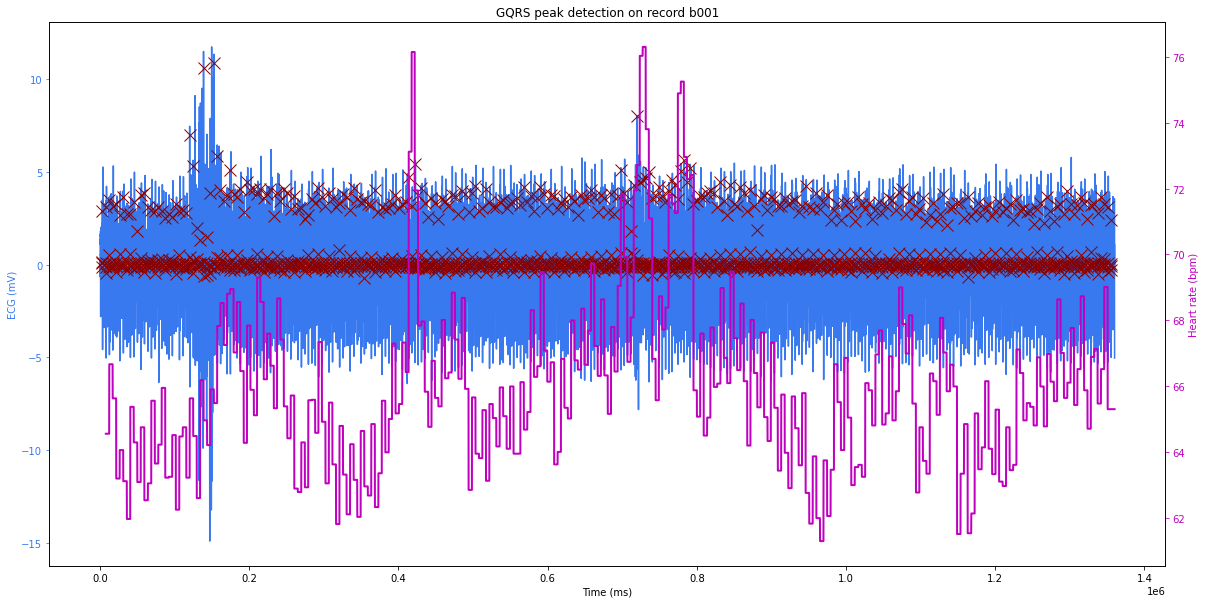

Corrected GQRS detected peak indices: [3270, 7916, 12419, 16987, 21735, 26421, 31171, 36014, 40602, 45266, 50022, 54655, 59451, 64212, 68789, 73501, 78172, 82719, 87465, 92205, 96859, 101676, 106332, 110963, 115709, 120280, 124929, 129717, 134266, 138870, 143544, 148097, 152684, 157102, 161481, 165941, 170302, 174651, 179127, 183506, 188017, 192687, 197109, 201660, 206265, 210597, 214970, 219502, 223942, 228443, 233036, 237407, 241853, 246441, 251102, 255665, 260434, 265214, 269880, 274645, 279222, 283794, 288440, 292897, 297516, 302274, 306855, 311569, 316422, 321054, 325790, 330618, 335292, 340040, 344877, 349518, 354281, 359068, 363696, 368504, 373243, 377818, 382504, 387121, 391581, 396182, 400765, 405221, 409737, 413840, 417780, 421948, 426371, 430785, 435342, 439976, 444469, 449037, 453627, 458038, 462565, 467083, 471442, 475889, 480422, 484791, 489339, 494114, 498683, 503373, 508075, 512670, 517420, 522005, 526617, 531292, 535842, 540450, 545132, 549678, 554367, 559059, 563595, 

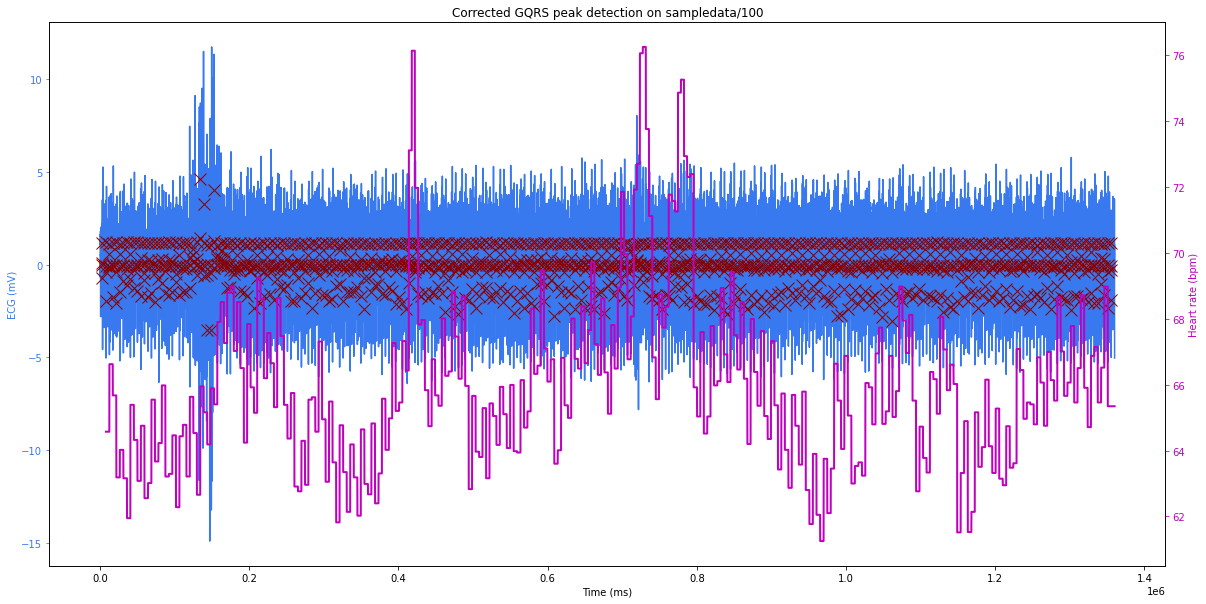

In [ ]:
# Load the WFDB record and the physical samples
#record = wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
hrs = peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record b001")
  
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
hrs = peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on sampledata/100")
    

[      nan       nan       nan ... 151.59172 151.59172 151.59172]


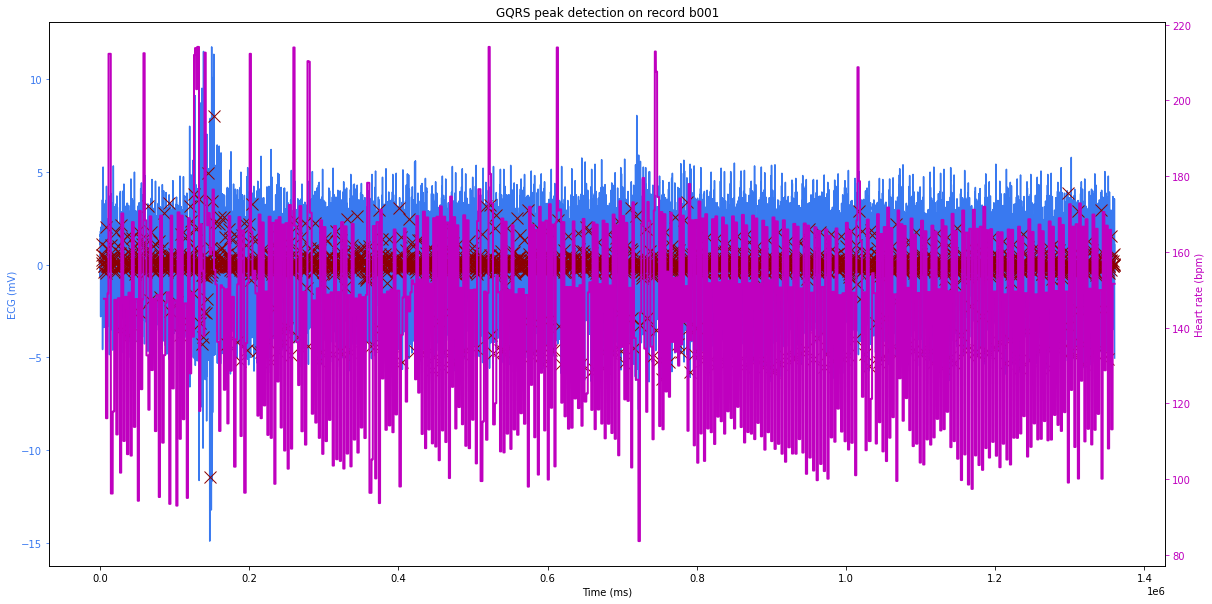

Corrected GQRS detected peak indices: [3365, 5344, 8026, 9983, 9983, 14484, 17103, 19065, 22251, 23784, 26923, 28489, 31282, 33252, 36549, 38069, 40714, 42668, 45374, 47343, 50537, 52102, 54773, 56754, 56754, 59561, 61524, 64743, 66257, 68886, 70876, 73605, 75567, 78713, 80193, 83225, 84797, 87574, 89536, 92733, 94303, 96971, 98935, 101789, 103751, 106876, 108409, 111051, 113040, 116233, 117791, 120376, 122355, 125037, 125037, 126831, 129128, 130234, 132718, 134405, 136338, 138495, 140934, 140934, 143647, 145593, 148194, 149186, 150258, 152802, 154726, 157213, 158164, 161217, 163539, 166037, 167989, 170415, 172347, 174757, 176713, 179649, 181168, 183638, 185577, 188125, 190096, 193209, 194731, 197193, 199182, 201755, 201762, 203722, 206370, 208331, 210694, 212653, 215058, 217028, 219599, 221556, 224050, 225991, 228551, 230489, 233548, 235083, 237517, 239462, 241957, 243890, 246539, 248468, 251198, 253189, 255772, 257712, 257712, 260535, 262490, 265324, 266283, 269984, 271941, 274757, 2

/usr/local/lib/python3.7/dist-packages/wfdb/processing/hr.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  hr = 60000.0 / rr


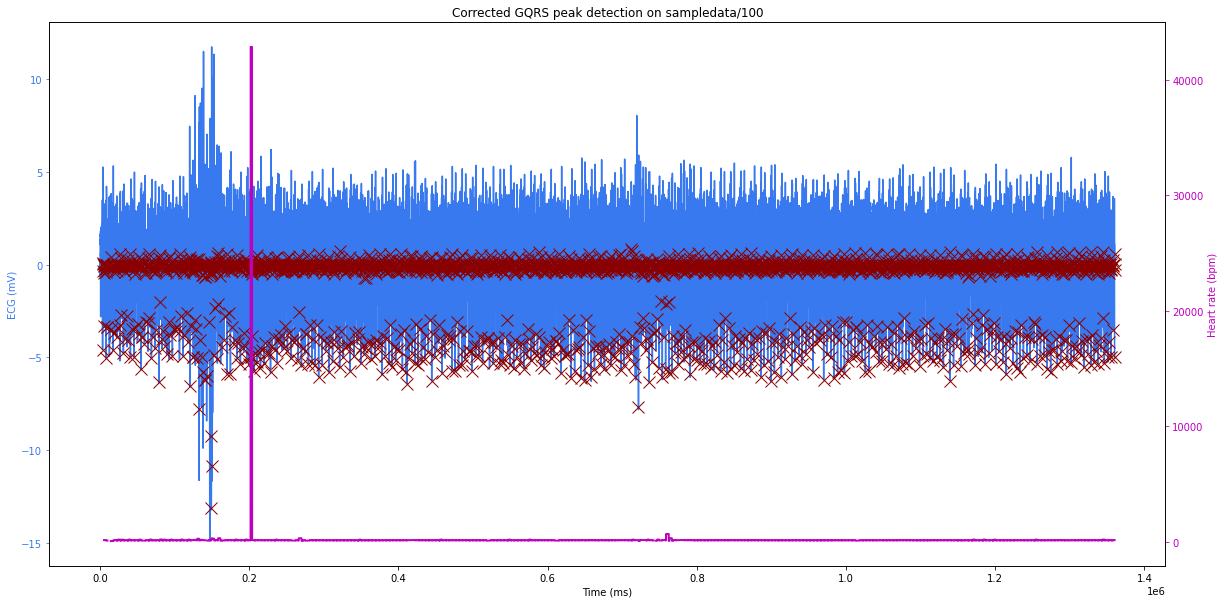

In [ ]:
# Load the WFDB record and the physical samples
#record = wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=10000, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,3], fs=record.fs)

# Plot results
hrs_scg = peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record b001")
  
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,3], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
hrs_scg = peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on sampledata/100")
    

In [ ]:
len(hrs)
hrs = hrs[~np.isnan(hrs)]
hrs=hrs[hrs<160]
#hrs=hrs[hrs>100]
print(len(hrs))

1352133


In [ ]:
len(hrs_scg)

hrs_scg = hrs_scg[~np.isnan(hrs_scg)]
hrs_scg=hrs_scg[hrs_scg<160]
#hrs_scg=hrs_scg[hrs_scg>100]
print(len(hrs_scg))

1235247


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0, 'ECG heart rate')

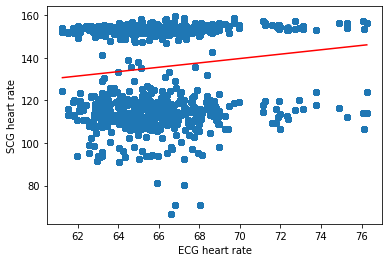

In [ ]:
# plotting the data
plt.scatter(hrs[:len(hrs_scg)], hrs_scg)
  
# This will fit the best line into the graph
plt.plot(np.unique(hrs), np.poly1d(np.polyfit(hrs[:len(hrs_scg)], hrs_scg, 1))
         (np.unique(hrs)), color='red')
plt.ylabel("SCG heart rate")
plt.xlabel("ECG heart rate")

In [ ]:
!pip install pyhrv

     |████████████████████████████████| 3.2 MB 7.1 MB/s 
     |████████████████████████████████| 85 kB 5.4 MB/s 
     |████████████████████████████████| 228 kB 74.8 MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95429 sha256=ac96dc978f85c3246f7384a36d05a663e0d641cd0e196343055ed6ec5eb1bdda
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
  Created wheel for spectrum: filename=spectrum-0.8.0-cp37-cp37m-linux_x86_64.whl size=234832 sha256=e75c3f14fa47b3a169ce422118fb5eb1b4fb36037d8957dbb396658f4113235d
  Stored in directory: /root/.cache/pip/wheels/ac/a0/2b/aba9ac3cce046bc454a44d0db5b711b4e927a0dd33a93e9d98
Successfully built biosppy spectrum


In [ ]:
# detect peaks
print(len(df.ECG))
print(len(df2.SCG))
print(len(df3.ECG_orig))
peaks_ecg_pred, similarity = detect_peaks(df.ECG, threshold=0.3)
peaks_scg, similarity = detect_peaks(df2.SCG, threshold=0.3)
peaks_ecg, similarity = detect_peaks(df3.ECG_orig, threshold=0.3)

print(len(peaks_ecg_pred))
print(len(peaks_scg))
print(len(peaks_ecg))
# group peaks so we get a single peak per beat (hopefully)

from scipy.ndimage import label
grouped_peaks_ecg_pred = group_peaks(peaks_ecg_pred)
grouped_peaks_scg = group_peaks(peaks_scg)
grouped_peaks_ecg = group_peaks(peaks_ecg)

print(len(grouped_peaks_ecg_pred))
print(len(grouped_peaks_scg))
print(len(grouped_peaks_ecg))
# RR-intervals are the differences between successive peaks
rr_ecg_pred = np.diff(grouped_peaks_ecg_pred)
rr_scg = np.diff(grouped_peaks_scg)
rr_ecg = np.diff(grouped_peaks_ecg)

print(len(rr_ecg_pred))
print(len(rr_scg))
print(len(rr_ecg))
# plot RR-intervals
#plt.figure(figsize=(20, 7))
#plt.title("RR-intervals")
#plt.xlabel("Time (ms)")
#plt.ylabel("RR-interval (ms)")

#plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8")
#plt.show()

68000
68000
68000
298
6910
5
73
667
0
72
666
0


In [ ]:

from matplotlib.patches import Ellipse
import seaborn as sns

In [ ]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

SD1: 318.271 ms
SD2: 332.916 ms


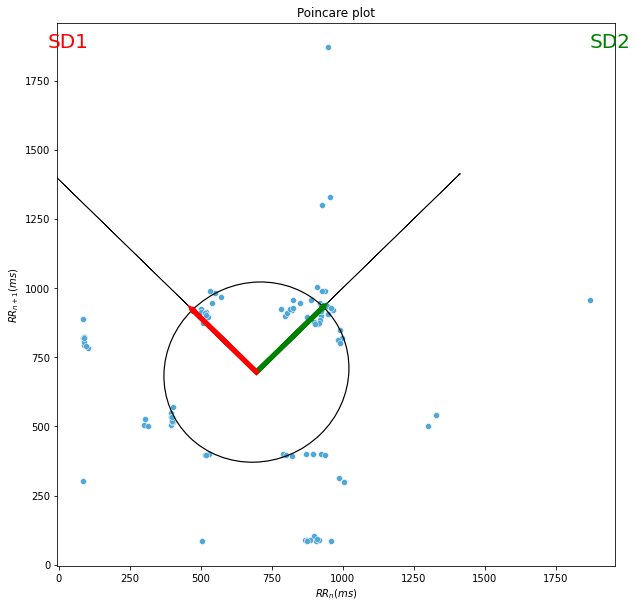

In [ ]:
sd1, sd2 = plot_poincare(rr_ecg_pred)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)

SD1: 127.006 ms
SD2: 97.189 ms


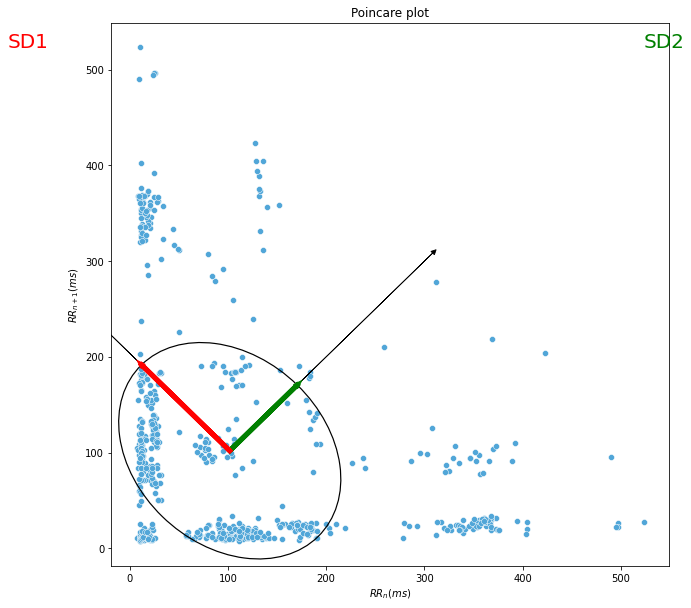

In [ ]:
sd1, sd2 = plot_poincare(rr_scg)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)

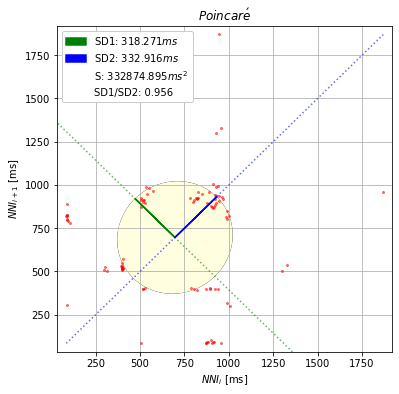

ReturnTuple(poincare_plot=<Figure size 432x432 with 1 Axes>, sd1=318.2709285082726, sd2=332.9156403672078, sd_ratio=1.0460133507247256, ellipse_area=332874.8951058909)

In [ ]:
import pyhrv
pyhrv.nonlinear.poincare(rr_ecg_pred,peaks_ecg_pred)

In [ ]:
from scipy.stats import pearsonr
true = y_test.astype('float')
pre =  x_g_AB.astype('float')
corr, pval =pearsonr(true.flatten(),pre.flatten())
print("corre and p-val:: ",corr, pval)


pre_smoothed =  x_g_AB_smoothed.astype('float')
corr_sm, pval_sm =pearsonr(true.flatten(),pre_smoothed.flatten())
print("smoothed corre and p-val:: ",corr_sm, pval_sm)

corre and p-val::  0.8771594584679292 0.0
smoothed corre and p-val::  0.8676956351707245 0.0


In [ ]:
accuracy_for_AtoB = 100 - (np.mean(np.abs(x_g_AB-y_test)*100))
print(accuracy_for_AtoB)

accuracy_for_AtoB_sm = 100 - (np.mean(np.abs(x_g_AB_smoothed-y_test)*100))
print("smoothed",accuracy_for_AtoB_sm)

69.45881279257877
smoothed 68.35461580130693


In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [ ]:
print(len(str(fileNames[0]))-4)

4


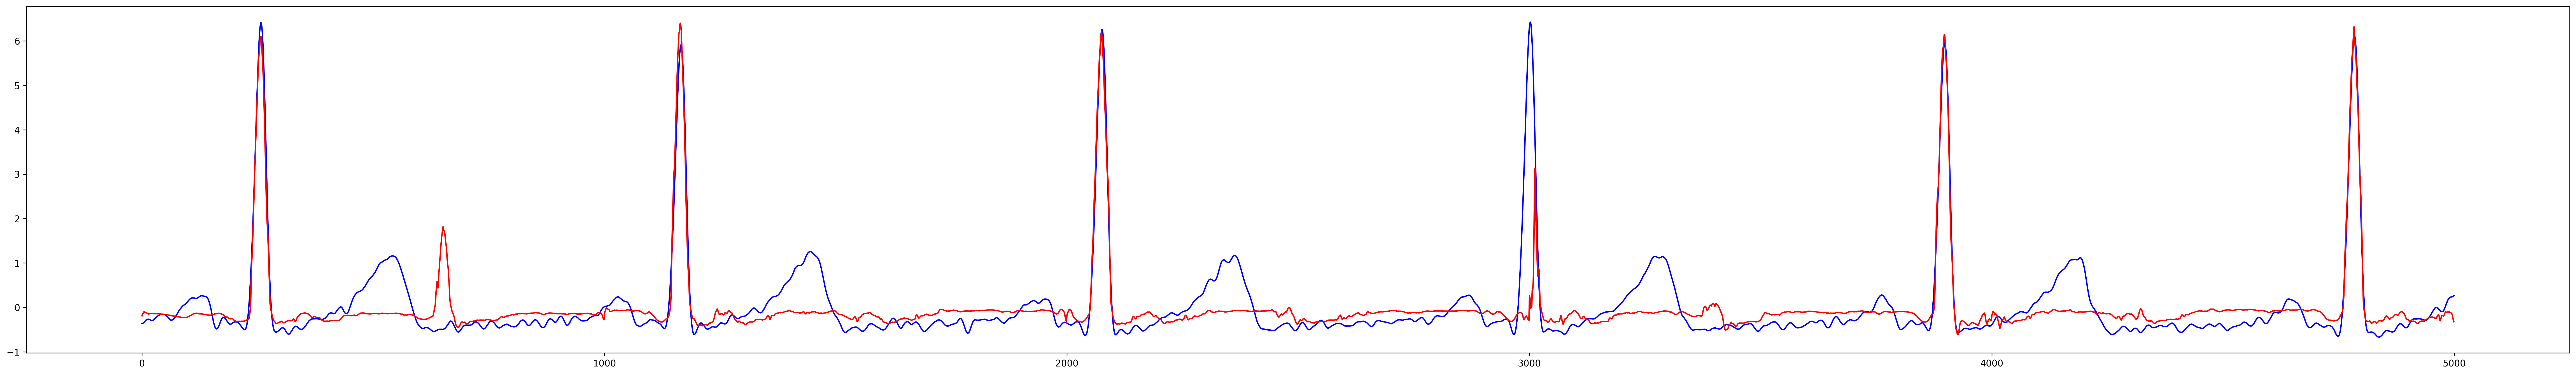

In [ ]:
from google.colab import files
fig = plt.figure(figsize=(4,3))
fig.set_size_inches(50,7)
plt.plot(y_test.flatten()[:5000],color="blue")
plt.plot(np.array(x_g_AB).flatten()[:5000], color="red")
plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/basal/b_to_b_'+str(fileNames[0])[0:len(str(fileNames[0]))-4]+'_first_5000.jpg')

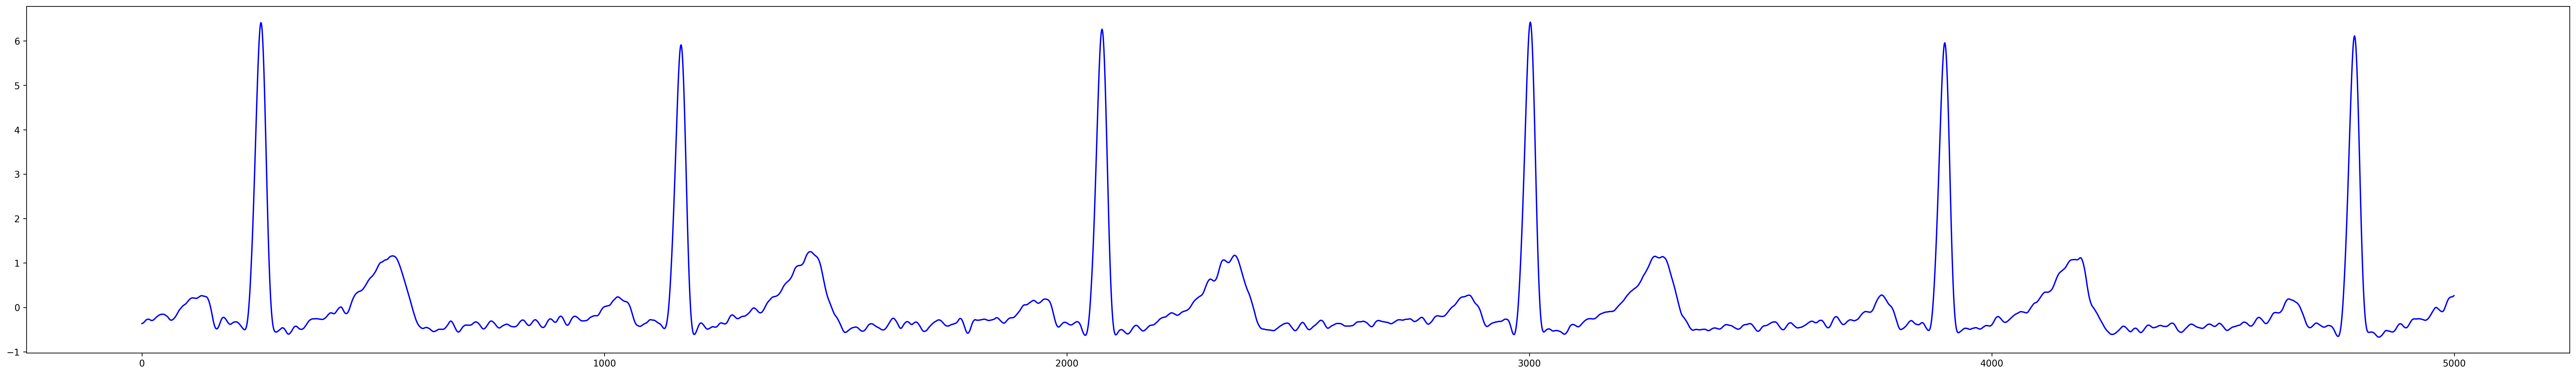

In [ ]:
from google.colab import files
fig = plt.figure(figsize=(4,3))
fig.set_size_inches(50,7)
plt.plot(y_test.flatten()[:5000],color="blue")
# plt.plot(np.array(x_g_AB).flatten()[:5000], color="red")
plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/basal/b_to_b_'+str(fileNames[0])[0:len(str(fileNames[0]))-4]+'_blue.jpg')

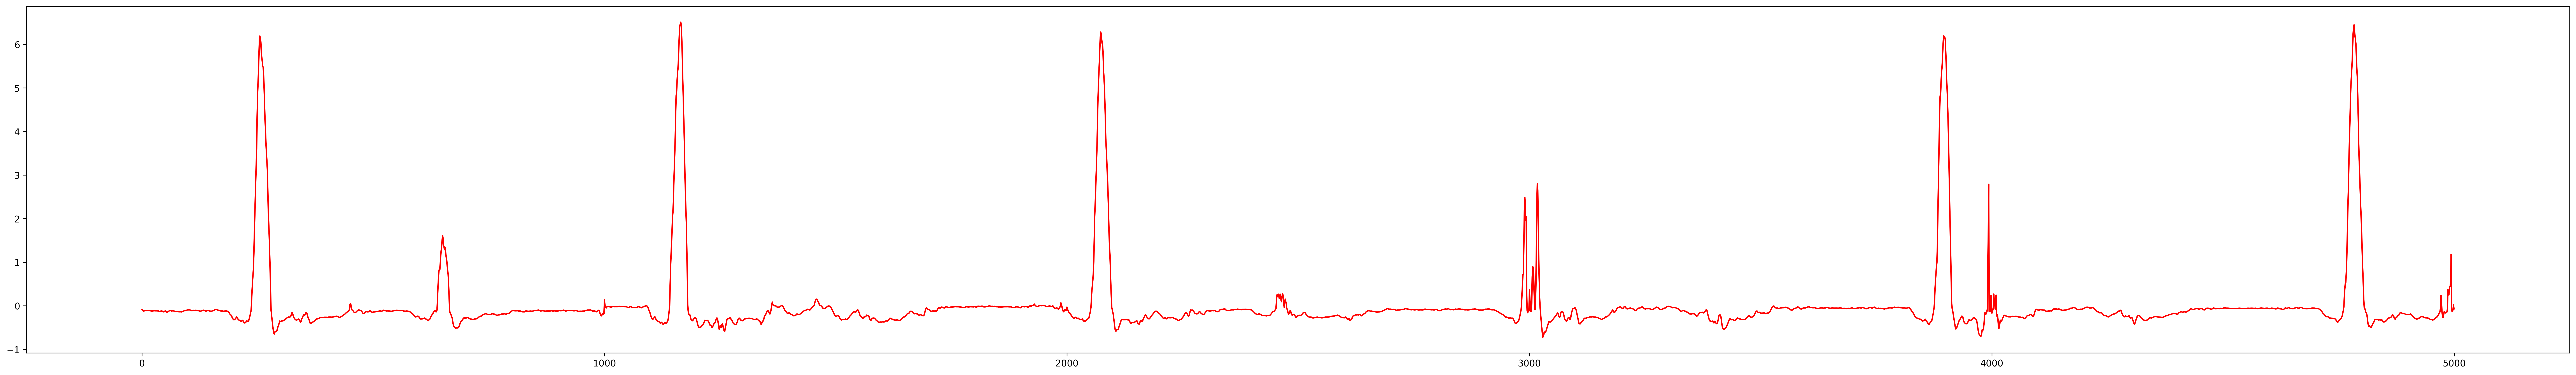

In [ ]:
from google.colab import files
fig = plt.figure(figsize=(4,3))
fig.set_size_inches(50,7)
# plt.plot(y_test.flatten()[:5000],color="blue")
plt.plot(np.array(x_g_AB).flatten()[:5000], color="red")
plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/basal/b_to_b_'+str(fileNames[0])[0:len(str(fileNames[0]))-4]+'_red.jpg')

In [ ]:
from google.colab import files
fig = plt.figure(figsize=(4,3))
fig.set_size_inches(50,7)
plt.plot(y_test.flatten()[:5000],color="blue")
plt.plot(np.array(x_g_AB_smoothed).flatten()[:5000], color="red")
plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/basal/b_to_b_'+str(fileNames[0])[0:len(str(fileNames[0]))-4]+'_first_5000_smoothed.jpg')

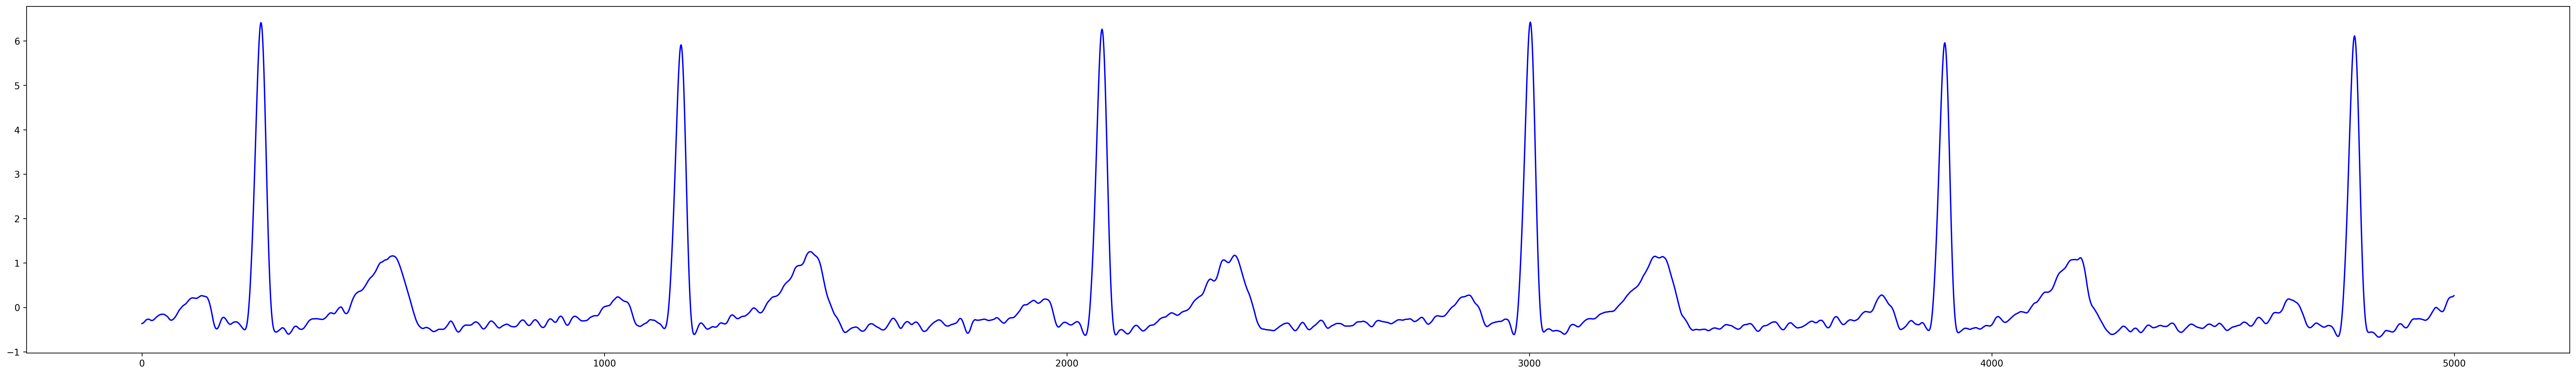

In [ ]:
from google.colab import files
fig = plt.figure(figsize=(4,3))
fig.set_size_inches(50,7)
plt.plot(y_test.flatten()[:5000],color="blue")
# plt.plot(np.array(x_g_AB_smoothed).flatten()[:5000], color="red")
plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/basal/b_to_b_'+str(fileNames[0])[0:len(str(fileNames[0]))-4]+'_blue_smoothed.jpg')

In [ ]:
from google.colab import files
fig = plt.figure(figsize=(4,3))
fig.set_size_inches(50,7)
# plt.plot(y_test.flatten()[:5000],color="blue")
plt.plot(np.array(x_g_AB_smoothed).flatten()[:5000], color="red")
plt.show()
fig.savefig('/content/drive/MyDrive/Colab Notebooks/basal/b_to_b_'+str(fileNames[0])[0:len(str(fileNames[0]))-4]+'_red_smoothed.jpg')

In [ ]:
# for i in range(len(y_test)):
#   fig = plt.figure(figsize=(4,3))
#   fig.set_size_inches(50,7)
#   plt.plot(y_test[i],color="blue")
#   plt.plot(x_g_AB[i], color="red")
#   plt.show()
#   plt.savefig('/content/drive/MyDrive/Colab Notebooks/GAN_PAPER_DATA/basal/b_to_b_1_batch_'+str(i+1)+'.jpg')

In [ ]:
# for i in range(len(y_test)):
#   fig = plt.figure(figsize=(4,3))
#   fig.set_size_inches(50,7)
#   plt.plot(y_test[i],color="blue")
#   plt.plot(x_g_AB_smoothed[i], color="red")
#   plt.savefig('/content/drive/MyDrive/Colab Notebooks/GAN_PAPER_DATA/basal/b_to_b_1_smoothed_batch_'+str(i+1)+'.jpg')
#   plt.show()

In [ ]:
# !pip install frechetdist

In [ ]:
# import sys
# print(sys.getrecursionlimit())
# sys.setrecursionlimit(5000)
# print(sys.getrecursionlimit())

In [ ]:
# from frechetdist import frdist
# fd = []
# for i in range(len(y_test)):
#   fd.append(frdist(y_test[i],x_g_AB[i]))
# print("FD: ", np.array(fd).mean())

In [ ]:

#mmd_arr = mmd(y_test,x_g_AB)

In [ ]:
# fd_mean = np.array(fd).mean()

In [ ]:
#To create the blank csv with header.

#from csv import writer 

#List=["Subject","Generator param A", "Generator param B","Reconstructor param A","Reconstructor param B","RMSE flattened", "RMSE Smoothed flattened","RMSE All Mean", "RMSE All Smoothed Mean", "prd", "prd smoothed","mae","mae smoothed", "correlation","correlation smoothed","p-val","p-val smoothed","accuracy","accuracy smoothed","frachet dist"] 
  
#with open('/content/drive/MyDrive/Colab Notebooks/GAN_PAPER_DATA/basal/matrices.csv', 'w') as f_object: 
  
#    writer_object = writer(f_object) 
#    writer_object.writerow(List) 
  
#    f_object.close() 

In [ ]:
# change the parameters here
gen_param_a = 0
gen_param_b = 0
rec_param_a = 0
rec_param_b = 0

In [ ]:
# List  
List_vals =[fileNames[0], gen_param_a,gen_param_b,rec_param_a,rec_param_b, rmse_arr, rmse_smoothed, rmse_all_mean, rmse_all_smoothed_mean, prd_arr, prd_arr_smoothed,mae_arr,mae_arr_smoothed, corr,corr_sm,pval,pval_sm,accuracy_for_AtoB,accuracy_for_AtoB_sm]

In [ ]:

from csv import writer 
 
with open('/content/drive/MyDrive/Colab Notebooks/basal/matrices.csv', 'a') as f_object: 
  
    writer_object = writer(f_object) 
    writer_object.writerow(List_vals) 
  
    f_object.close() 

In [ ]:
# !pip install torch

In [ ]:
# !pip install -c dloewenstein torch-two-sample

In [ ]:
#!pip install mmd

In [ ]:
# !pip install torch torchvision



In [ ]:
# from torch_two_sample.statistics_diff import MMDStatistic
# print(mmd(y_test,x_g_AB))

In [ ]:
#!pip install ecg_plot

In [ ]:
#import ecg_plot

In [ ]:
#for i in range(10):
#  ecg_plot.plot_1(y_test_scaled[i], sample_rate=500, title = 'Original ECG')
 # ecg_plot.plot_1(x_g_AB_scaled[i], sample_rate=500, title = 'Predicted ECG')
  #plt.tight_layout()
 # ecg_plot.show()

In [ ]:

#ecg_plot.plot_1(y_test.flatten(), sample_rate=1000, title = 'Original')
#ecg_plot.plot_1(x_g_AB.flatten(), sample_rate=1000, title = 'Predicted')

In [ ]:
#x = y_test[0].flatten().tolist()
#y = x_g_AB[0].flatten().tolist()
#for i in range(len(x_g_AB)):
#  x.append((y_test[i][len(y_test[i])-1])[0])
#  y.append((x_g_AB[i][len(x_g_AB[i])-1])[0])

In [ ]:
print("acc: %3d%%"% accuracy_for_AtoB)

In [ ]:
# normalize correlation
a = (y_test - np.mean(y_test)) / (np.std(y_test) * len(y_test))
b = (x_g_AB - np.mean(x_g_AB)) / (np.std(x_g_AB))
c = np.correlate(a.flatten(), b.flatten(), 'full')
print(c)

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test.flatten(), x_g_AB.flatten())
print(mse)

0.2238387664155721


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test.flatten(), x_g_AB.flatten())
print(mae)

In [ ]:
y_pred = x_g_AB.flatten()
y_test_new = y_test.flatten()

In [ ]:

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [ ]:

y_test_new[y_test_new > 0.5] = 1
y_test_new[y_test_new <= 0.5] = 0

In [ ]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score


In [ ]:

print("accuracy_score",accuracy_score(y_test_new, y_pred)) 

In [ ]:

print("precision_score",precision_score(y_test_new, y_pred , pos_label='positive', average='micro')) 

In [ ]:

print("f1_score",f1_score(y_test_new, y_pred, pos_label='positive', average='micro')) 

In [ ]:

print("recall_score",recall_score(y_test_new, y_pred, pos_label='positive', average='micro')) 

In [ ]:
from sklearn.metrics import confusion_matrix
a = [1,1,1,1,1,0]
b=[1,1,1,1,0,0]
matrix = confusion_matrix(y_test_new, y_pred)
print(matrix) 

In [ ]:
# correlation coefficient r of x and y
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_new, y_pred)
print (r_value)

In [ ]:
# The coefficient of determination
from sklearn.metrics import r2_score
print(r2_score(y_test_new, y_pred))